# Evaluation Metrics for Classification

* Use the same data as in the previous session: Churn Prediction (Identify clients that want to leave the company)
* Data https://www.kaggle.com/blastchar/telco-customer-churn

## Review of previous Session

* Metrics: A function, that compares the actual values with the predicted values. It outputs a single umber that measures the goodness of the model

### Setup

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

### Load Data

In [3]:
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

### Data Preparation

In [8]:
# Unify column names
df.columns = df.columns.str.lower().str.replace(" ", "_")
# List of all categorical columns
categorical_columns = list(df.dtypes[df.dtypes == object].index)
# Unify categolrical columns
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_")

# Change "totalcharges to numeric and fill na with 0
df.totalcharges = pd.to_numeric(df["totalcharges"], errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)

# Change "churn" to type int
df["churn"] = (df["churn"] == "yes").astype(int)

### Model Setup

In [10]:
# 80% train + val = train_full, 20% test
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
# 75% train, 25% val out of train_full 
# 60% train, 20% val, 20% test out of df
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["churn"]
y_val = df_val["churn"]
y_test = df_test["churn"]

# delete "churn from df_train, df_val, df_test (not from df)
del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

In [11]:
numerical = ["tenure", "monthlycharges", "totalcharges"]
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [13]:
# First convert to dictionary
train_dicts = df_train[categorical+numerical].to_dict(orient="records")

dv = DictVectorizer(sparse=False) # don't use sparse matrix
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)

val_dicts = df_val[categorical+numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/jens/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Predictions

In [14]:
y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred > 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## Accuracy and Dummzy Model

* Evaluate the model on different thresholds
* Check the accuracy of the dummy baseline

In [19]:
# How many validation values do we have?
len(y_val)

1409

In [20]:
# How many correct decisions did we take?
(y_val == churn_decision).sum()

1132

* Accruracy: Correct Prediction / All Predictions

In [21]:
1132/1409

0.8034066713981547

* Is the threshold of 0.5 good?
* Test the model with different thresholds

In [22]:
thresholds = np.linspace(0,1,21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [28]:
scores = []
for t in thresholds:
    churn_decision = (y_pred > t)
    score = (y_val == churn_decision).mean()
    print(f"threshold: {t:.2f}, score: {score:.3f}")
    scores.append(score)

threshold: 0.00, score: 0.274
threshold: 0.05, score: 0.510
threshold: 0.10, score: 0.591
threshold: 0.15, score: 0.666
threshold: 0.20, score: 0.710
threshold: 0.25, score: 0.739
threshold: 0.30, score: 0.760
threshold: 0.35, score: 0.772
threshold: 0.40, score: 0.785
threshold: 0.45, score: 0.794
threshold: 0.50, score: 0.803
threshold: 0.55, score: 0.801
threshold: 0.60, score: 0.796
threshold: 0.65, score: 0.786
threshold: 0.70, score: 0.766
threshold: 0.75, score: 0.744
threshold: 0.80, score: 0.734
threshold: 0.85, score: 0.726
threshold: 0.90, score: 0.726
threshold: 0.95, score: 0.726
threshold: 1.00, score: 0.726


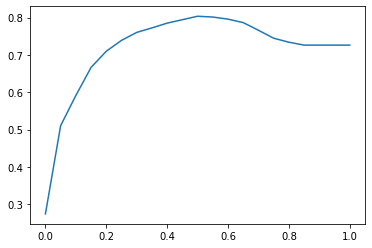

In [29]:
plt.plot(thresholds, scores);

* Here 0.5 is the best threshold, before and afterwards the accuracy is lower
* Scikit-learn provides a function for the accuracy (above we wrote our own function)

In [30]:
from sklearn.metrics import accuracy_score

In [33]:
accuracy_score(y_val, (y_pred > 0.5))

0.8034066713981547

* Special cases: threshold = 0 and threshold = 1
* threshold = 1 means, we are predicting that no customer is churning
    * For this case (Dummy Model) the accuracy is ~73%
* threshold = 0 means, we are predicting that all customers are churning
* Our model gives an accuracy of 0.8

In [37]:
# non-churning users
1 - y_val.mean()

0.7260468417317246

* In this data set that are much more non-churning than churning users
* We have class imbalance in this data set
    * For class imbalance, predicting the majority class already gives quite good accuracy and accuracy can be a misleading metric

## Confusion Table

* Different types of errors and correct decisions
* Arranging them in a table

![confusion_table](Screenshot1.png "Confusion Table")
![confusion_table](Screenshot2.png "Confusion Table")

In [43]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [46]:
tp = (predict_positive & actual_positive).sum()
tp

210

In [47]:
tn = (predict_negative & actual_negative).sum()
tn

922

In [48]:
fp = (predict_positive & actual_negative).sum()
fp

101

In [49]:
fn = (predict_negative & actual_positive).sum()
fn

176

In [50]:
confusion_matrix = np.array([
                        [tn, fp],
                        [fn, tp]])
confusion_matrix

array([[922, 101],
       [176, 210]])

* We have a lot of more false negatives than false positives
    * False positives are predicted to churn, but they are not going to. We would send them a discount e-mail, though not necessary and would loose profit
    * False positives are not receiving an e-mail and are leaving, also loosing profit in this case

In [51]:
# in relative numbers
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

![confusion_table](Screenshot3.png "Confusion Table")

## Precission and Recall

* Very useful for binary clasification problems

In [53]:
# Accuracy
(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

Now we will look at other metrics:
* **Precision: Fraction of positive predictions that are correct**
    * tp / (tp + fp)

In [56]:
p = tp / (tp + fp)
p

0.6752411575562701

* This means that (1-p)~33% will get a promotional e-mail, although they are not going to churn 

* **Recall: Fraction of correctly identified positive examples**
    * tp / (tp + fn) = tp / (#positive observations)

In [59]:
r = tp / (tp + fn)
r

0.5440414507772021

* This means that we failed to identify (1-r)~46% of people who are churning 

## ROC Curves

### TPR and FRP

### Random Model

### Ideal Model

## ROC AUC

* Area under the ROC curve - useful metric for binary classification
* Getting the average prediction and the spread within predictions

### Cross Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

### Summary

* Metric: A single number that describes the performance of a model
* Accuracy: fraction of correct answers; sometimes misleading
* Precision and Recall are less misleading when we have class imbalance
* ROC curve: A way to evaluate the performance at all thresholds; ok to use with class imbalance
* K-fold Cross Validation: more reliable estimate for performance (mean + std)